* <font color="red">assignment problem</font>. The red color indicates the task that should be done
* <font color="green">debugging</font>. The green tells you what is expected outcome. Its primarily goal is to help you get the correct answer
* <font color="blue">comments, hints</font>.

Assignment 3 (CNN)
======================


**Useful References:**
* official pytorch cifar10 tutorial


https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* tensorboard in colab


https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks
* tensorboard & colab


https://colab.research.google.com/drive/1NbEqqB42VSzYt-mmb4ESc8yxL05U2TIV


https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34



## Preliminaries


#### Check the environment

In [1]:
!pwd

/Users/astadnik/edu/masters/sem_3/CV/5/ucu2022cv/assignments


In [2]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


#### Install missing packages

In [3]:
# [colab version] latest version of tensorflow in order to use tensorboard inside the notebook
# !pip install -q tf-nightly-2.0-preview

#### Load libs, set settings

In [4]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

In [5]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

In [6]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# for auto-reloading external modules (files, etc.)
%load_ext autoreload
%autoreload 2

# to be able to make plots inline the notebook
# (actually no need for the colab version)
%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({"font.size": 18, "font.family": "serif"})

## Define pathes

In [7]:
# path for dataset (will be not there after end of session)
path_data = "./data"

## Data

Using ``torchvision`` load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root=path_data, train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root=path_data, train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
!ls data

cifar-10-batches-py    cifar-10-python.tar.gz toy_data


Let us show some of the training images, for fun.



 frog plane  deer   car


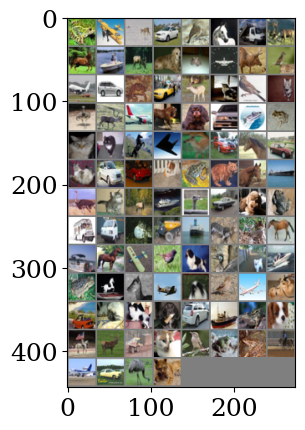

In [10]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

## Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [11]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function

Let's use a Classification Cross-Entropy loss



In [13]:
criterion = nn.CrossEntropyLoss()

## Set-up training




In [14]:
def train_epoch(train_loader, model, criterion, optimizer, scheduler, epoch, device):
    # switch to train mode
    model.train()

    with tqdm(train_loader, leave=False) as pbar:
        for batch_idx, (input_data, target) in enumerate(pbar):
            # extract batch data
            target = target.to(device)
            input_data = input_data.to(device)

            # compute output
            output = model(input_data)
            loss = criterion(output, target)

            # compute gradient and do optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # logging
            # if batch_idx % log_interval == 0:
            pbar.set_description(f"Loss: {loss.item():.6f}")

            n = len(train_loader.dataset)
            i = epoch * n + batch_idx * len(input_data)
            # log loss
            writer.add_scalar("Train/RunningLoss", loss.item(), i)
            # log LR
            # if scheduler is not None:
            #     lr = scheduler.get_last_lr()[0]
            #     writer.add_scalar("Train/LearningRate", lr, i)

    # adjust_learning_rate
    if scheduler is not None:
        scheduler.step()

## Logging

In [15]:
# path for dataset (will be not there after end of session)
# current_time = str(datetime.datetime.now().timestamp())
path_log = "logs/tensorboard/original"

# set-up writer
writer = SummaryWriter(path_log)

In [16]:
# Model (and Images) to TensorBoard (TB)

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)

# net to TB
writer.add_graph(net.cpu(), images)

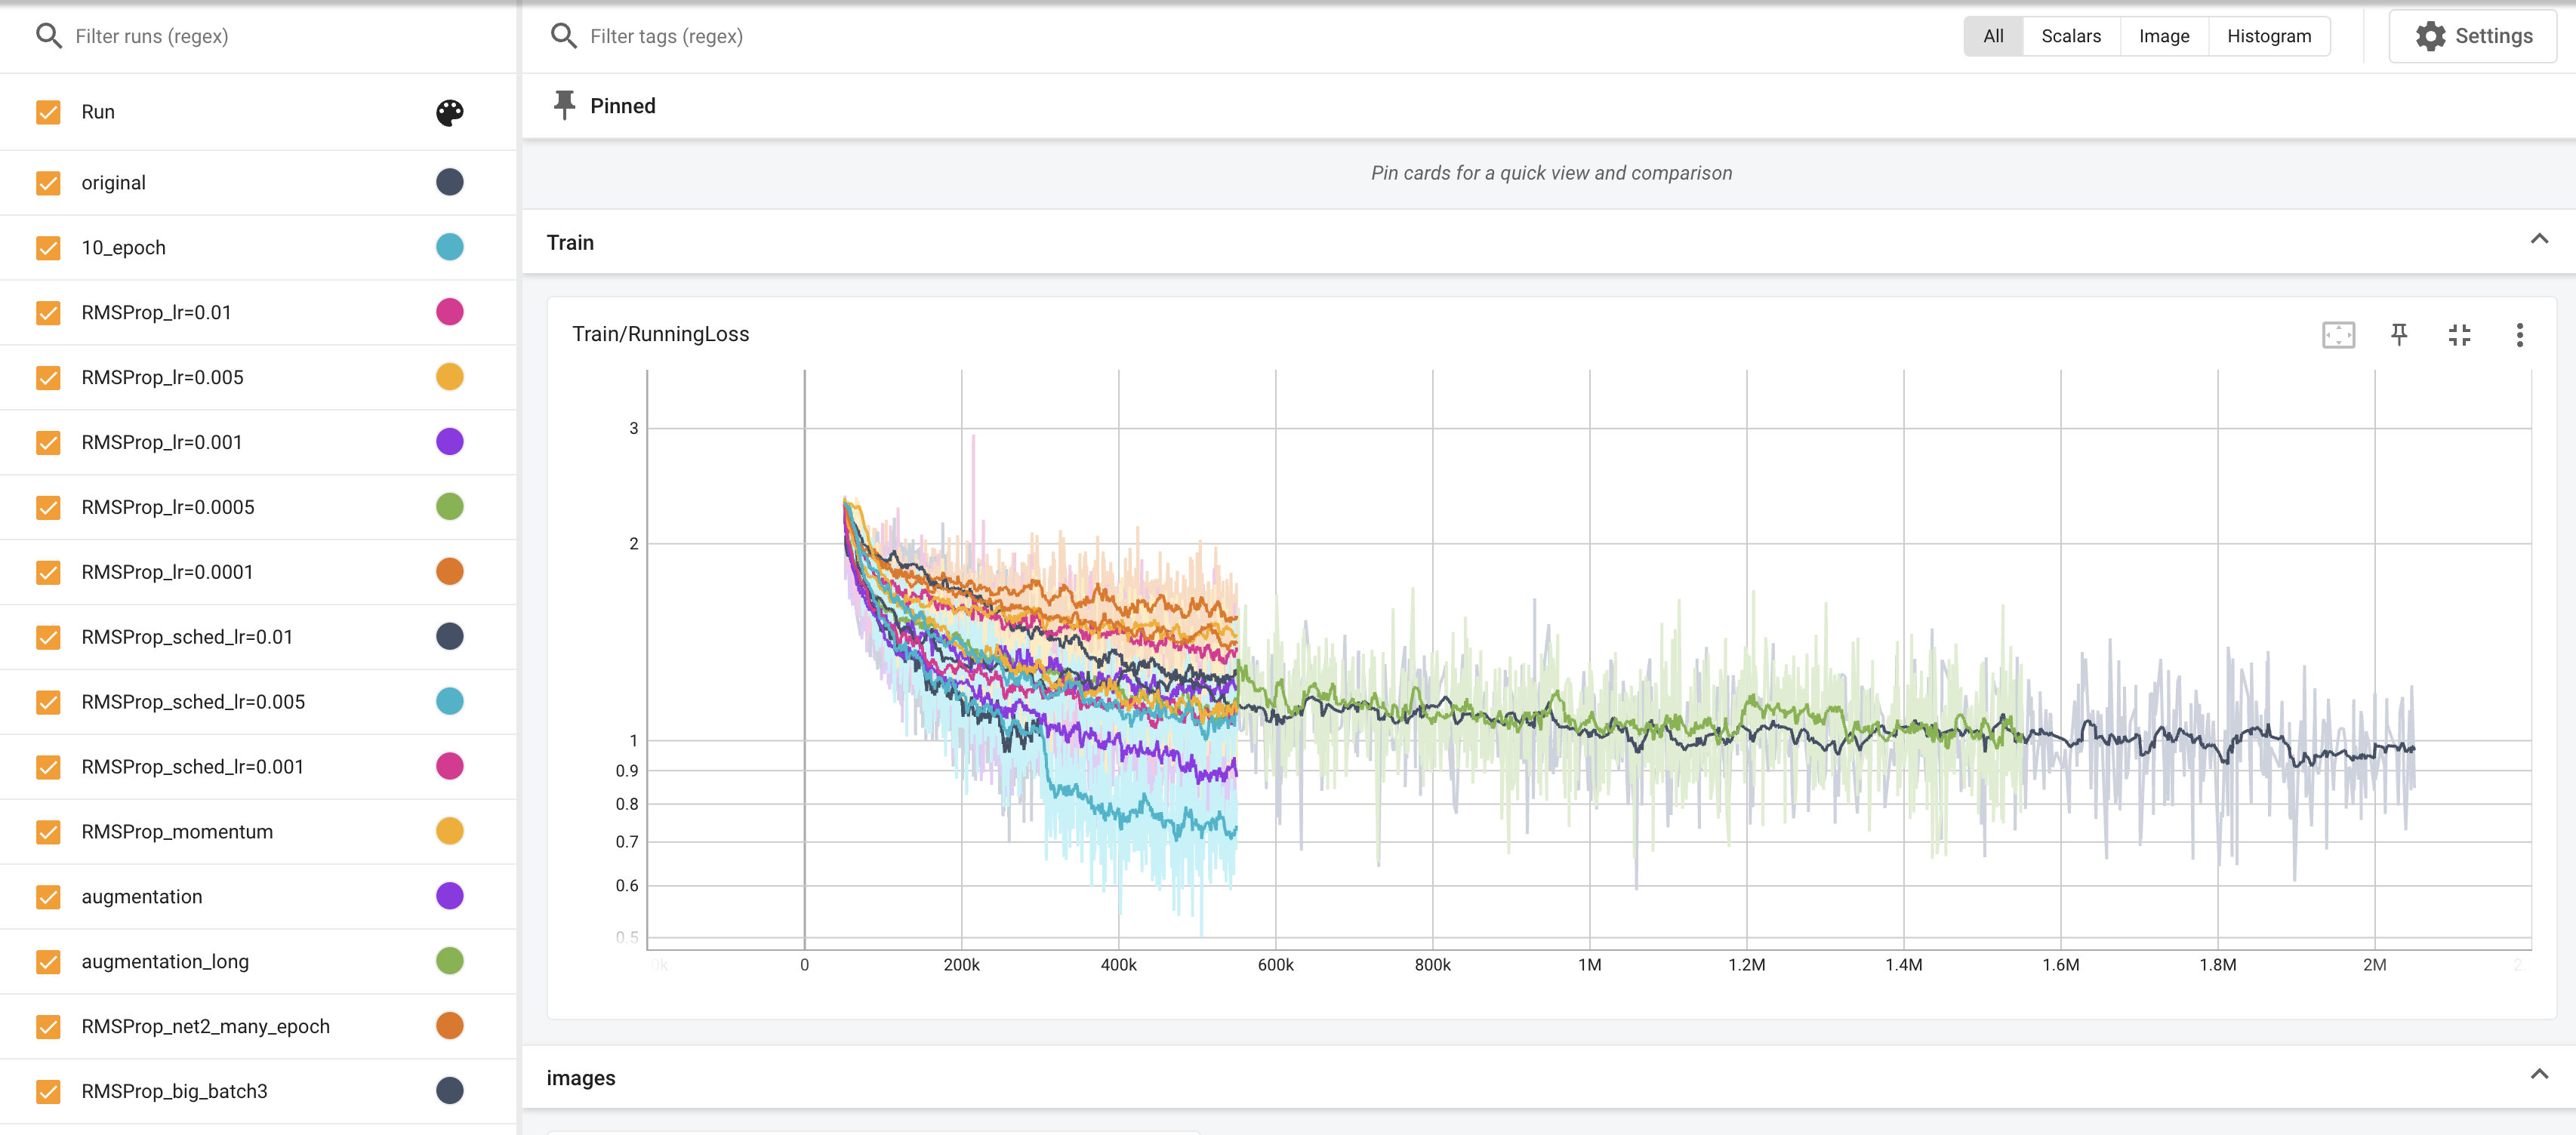

In [17]:
%tensorboard --logdir logs/tensorboard

In [18]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Training

In [19]:
# set number of epoch
n_epochs = 5

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, "mps")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
!ls logs/tensorboard/

original


In [21]:
# !rm -r logs/tensorboard/*

##  Test the network on the test data





In [22]:
# switch to test mode
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

GroundTruth:    cat  ship  ship plane


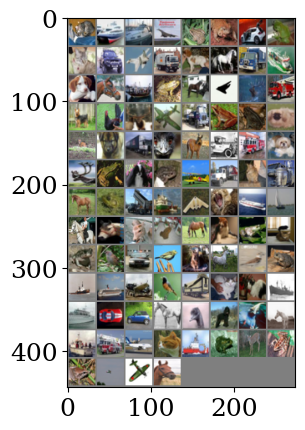

In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [24]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship plane




Let us look at how the network performs on the whole dataset.



In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    "Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total)
)

Accuracy of the network on the 10000 test images: 62 %


the classes that performed well, and the classes that did
not perform well:



In [26]:
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print(
        "Accuracy of %5s : %2d %%"
        % (classes[i], 100 * class_correct[i] / class_total[i])
    )

Accuracy of plane : 72 %
Accuracy of   car : 81 %
Accuracy of  bird : 28 %
Accuracy of   cat : 39 %
Accuracy of  deer : 42 %
Accuracy of   dog : 53 %
Accuracy of  frog : 81 %
Accuracy of horse : 68 %
Accuracy of  ship : 75 %
Accuracy of truck : 75 %


## Tasks

### <font color="red"> **[PROBLEM I]**: </font>   
 <font color="red"> To get at least 65% accuracy on the validation set </font> 


#### Things to try:
- Filter size
- Number of filters
- Batch normalization
- Network architecture. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [FC]xM 
    - [conv-relu-pool]XN - [FC]XM 
    - [conv-relu-conv-relu-pool]xN - [FC]xM 

#### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

#### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. 

- Alternative update steps:  SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation


#### What to expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! 




### Eval (for convenience)

In [27]:
def evaluate(net):
    # switch to test mode
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device)).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    tqdm.write(
        "Accuracy of the network on the 10000 test images: %d %%"
        % (100 * correct / total)
    )

    # the classes that performed well, and the classes that did
    # not perform well:

    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device)).cpu()
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        tqdm.write(
            "Accuracy of %5s : %2d %%"
            % (classes[i], 100 * class_correct[i] / class_total[i])
        )

# Note

Note, that I have increased the batch size, and, consequently, the learning rate for more smooth loss curve.

# More epoch

In [28]:
path_log = "logs/tensorboard/10_epoch"
writer = SummaryWriter(path_log)

net = Net().to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# set number of epoch
n_epochs = 10

for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
evaluate(net)

Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 81 %
Accuracy of   car : 87 %
Accuracy of  bird : 44 %
Accuracy of   cat : 34 %
Accuracy of  deer : 57 %
Accuracy of   dog : 53 %
Accuracy of  frog : 77 %
Accuracy of horse : 75 %
Accuracy of  ship : 70 %
Accuracy of truck : 75 %


Hehe, done!

### RMSProp

In [30]:
for lr in [0.01, 0.005, 0.001, 0.0005, 0.0001]:
    name = f"RMSProp_lr={lr}"
    tqdm.write(name)
    path_log = f"logs/tensorboard/{name}"
    writer = SummaryWriter(path_log)

    net = Net().to(device)

    # set-up optimizer and scheduler
    optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
    scheduler = None

    for epoch in trange(1, n_epochs + 1):
        train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

    evaluate(net)

RMSProp_lr=0.01


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 51 %
Accuracy of plane : 52 %
Accuracy of   car : 59 %
Accuracy of  bird : 10 %
Accuracy of   cat : 39 %
Accuracy of  deer : 44 %
Accuracy of   dog : 34 %
Accuracy of  frog : 71 %
Accuracy of horse : 78 %
Accuracy of  ship : 43 %
Accuracy of truck : 72 %
RMSProp_lr=0.005


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 58 %
Accuracy of plane : 63 %
Accuracy of   car : 75 %
Accuracy of  bird : 47 %
Accuracy of   cat : 37 %
Accuracy of  deer : 63 %
Accuracy of   dog : 59 %
Accuracy of  frog : 71 %
Accuracy of horse : 71 %
Accuracy of  ship : 75 %
Accuracy of truck : 51 %
RMSProp_lr=0.001


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 52 %
Accuracy of   cat : 34 %
Accuracy of  deer : 59 %
Accuracy of   dog : 56 %
Accuracy of  frog : 77 %
Accuracy of horse : 78 %
Accuracy of  ship : 72 %
Accuracy of truck : 41 %
RMSProp_lr=0.0005


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 72 %
Accuracy of   car : 71 %
Accuracy of  bird : 39 %
Accuracy of   cat : 44 %
Accuracy of  deer : 48 %
Accuracy of   dog : 56 %
Accuracy of  frog : 66 %
Accuracy of horse : 68 %
Accuracy of  ship : 64 %
Accuracy of truck : 58 %
RMSProp_lr=0.0001


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 48 %
Accuracy of plane : 52 %
Accuracy of   car : 62 %
Accuracy of  bird : 18 %
Accuracy of   cat : 18 %
Accuracy of  deer : 28 %
Accuracy of   dog : 37 %
Accuracy of  frog : 75 %
Accuracy of horse : 56 %
Accuracy of  ship : 56 %
Accuracy of truck : 62 %


In [31]:
for lr in [0.01, 0.005, 0.001]:
    name = f"RMSProp_sched_lr={lr}"
    tqdm.write(name)
    path_log = f"logs/tensorboard/{name}"
    writer = SummaryWriter(path_log)

    net = Net().to(device)

    # set-up optimizer and scheduler
    optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    for epoch in trange(1, n_epochs + 1):
        train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

    evaluate(net)

RMSProp_sched_lr=0.01


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 51 %
Accuracy of plane : 59 %
Accuracy of   car : 68 %
Accuracy of  bird : 23 %
Accuracy of   cat : 34 %
Accuracy of  deer : 44 %
Accuracy of   dog : 43 %
Accuracy of  frog : 67 %
Accuracy of horse : 68 %
Accuracy of  ship : 43 %
Accuracy of truck : 48 %
RMSProp_sched_lr=0.005


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 63 %
Accuracy of   car : 65 %
Accuracy of  bird : 44 %
Accuracy of   cat : 30 %
Accuracy of  deer : 40 %
Accuracy of   dog : 46 %
Accuracy of  frog : 66 %
Accuracy of horse : 78 %
Accuracy of  ship : 58 %
Accuracy of truck : 55 %
RMSProp_sched_lr=0.001


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 58 %
Accuracy of plane : 65 %
Accuracy of   car : 75 %
Accuracy of  bird : 39 %
Accuracy of   cat : 34 %
Accuracy of  deer : 61 %
Accuracy of   dog : 43 %
Accuracy of  frog : 79 %
Accuracy of horse : 65 %
Accuracy of  ship : 75 %
Accuracy of truck : 51 %


Well, it kind of works, but it's not that better than the original optimizer.

### RMSProp with momentum

In [32]:
path_log = "logs/tensorboard/RMSProp_momentum"
writer = SummaryWriter(path_log)

In [33]:
net = Net().to(device)

In [34]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, momentum=0.9)

for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
evaluate(net)

Accuracy of the network on the 10000 test images: 44 %
Accuracy of plane : 61 %
Accuracy of   car : 81 %
Accuracy of  bird : 44 %
Accuracy of   cat : 18 %
Accuracy of  deer : 22 %
Accuracy of   dog : 37 %
Accuracy of  frog : 67 %
Accuracy of horse : 65 %
Accuracy of  ship : 20 %
Accuracy of truck : 31 %


Same, it kind of works, but it's not that better than the original optimizer.

### Data augmentation

In [36]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


trainset = torchvision.datasets.CIFAR10(
    root=path_data, train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=50, shuffle=True, num_workers=4
)

# testset = torchvision.datasets.CIFAR10(
#     root=path_data, train=False, download=True, transform=transform
# )
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=4, shuffle=False, num_workers=4
# )

Files already downloaded and verified


In [37]:
path_log = "logs/tensorboard/augmentation"
writer = SummaryWriter(path_log)

net = Net().to(device)

optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)

for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

In [38]:
evaluate(net)

Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 68 %
Accuracy of   car : 84 %
Accuracy of  bird : 63 %
Accuracy of   cat : 44 %
Accuracy of  deer : 48 %
Accuracy of   dog : 46 %
Accuracy of  frog : 73 %
Accuracy of horse : 71 %
Accuracy of  ship : 83 %
Accuracy of truck : 55 %


Well, the results are worse, but data augmentation should increase the accuracy, while possibly making the learning worse.

### Let's increase the number of epochs

In [39]:
path_log = "logs/tensorboard/augmentation_long"
writer = SummaryWriter(path_log)

n_epochs_long = 20

for epoch in trange(n_epochs + 1, n_epochs + n_epochs_long + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

evaluate(net)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [02:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 88 %
Accuracy of   car : 87 %
Accuracy of  bird : 42 %
Accuracy of   cat : 39 %
Accuracy of  deer : 59 %
Accuracy of   dog : 65 %
Accuracy of  frog : 71 %
Accuracy of horse : 84 %
Accuracy of  ship : 75 %
Accuracy of truck : 58 %


### BatchNorm + Dropout

In [40]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_p)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [41]:
path_log = "logs/tensorboard/RMSProp_net2_many_epoch"
writer = SummaryWriter(path_log)

optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)

for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

evaluate(net)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [01:44<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [02:04<?, ?it/s]

Accuracy of the network on the 10000 test images: 46 %
Accuracy of plane : 56 %
Accuracy of   car : 46 %
Accuracy of  bird : 39 %
Accuracy of   cat : 27 %
Accuracy of  deer : 42 %
Accuracy of   dog : 21 %
Accuracy of  frog : 67 %
Accuracy of horse : 53 %
Accuracy of  ship : 52 %
Accuracy of truck : 27 %


Doesn't really work???

### Big batch 3

In [42]:
# path for dataset (will be not there after end of session)
# current_time = str(datetime.datetime.now().timestamp())
path_log = "logs/tensorboard/RMSProp_big_batch3"

# set-up writer
writer = SummaryWriter(path_log)

In [43]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [44]:
net = Net().to(device)

In [45]:
# set number of epoch
n_epochs = 20

# set-up optimizer and scheduler
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
scheduler = None

# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


for epoch in trange(1, n_epochs + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [02:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

In [46]:
evaluate(net)

Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 84 %
Accuracy of   car : 84 %
Accuracy of  bird : 28 %
Accuracy of   cat : 48 %
Accuracy of  deer : 59 %
Accuracy of   dog : 62 %
Accuracy of  frog : 64 %
Accuracy of horse : 75 %
Accuracy of  ship : 89 %
Accuracy of truck : 68 %


Combined what worked best the results are promising!

### Looks that it works fine, let's keep going!

In [47]:
for epoch in trange(n_epochs + 1, n_epochs + n_epochs_long + 1):
    train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [02:24<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [02:24<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

  0%|          | 0/1000 [00:04<?, ?it/s]

In [48]:
evaluate(net)

Accuracy of the network on the 10000 test images: 68 %
Accuracy of plane : 75 %
Accuracy of   car : 87 %
Accuracy of  bird : 44 %
Accuracy of   cat : 37 %
Accuracy of  deer : 63 %
Accuracy of   dog : 46 %
Accuracy of  frog : 66 %
Accuracy of horse : 87 %
Accuracy of  ship : 85 %
Accuracy of truck : 55 %


The final result looks pretty dope!